# Time Series Forecasting Project

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import *
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
import os
from pickle import dump

In [12]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
df = pd.read_csv(url)
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [13]:
print(f'Shape: {df.shape}')
print(f'''Nan Values: 
      {df.isna().sum()}''')
df.info()

Shape: (366, 2)
Nan Values: 
      date     0
sales    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [14]:
print(f'Number of duplicated rows: {df.duplicated().sum()}')

Number of duplicated rows: 0


## Step 2: Construct and analyze the time serie

Construct the valid data structure for the time serie, graph it, 

In [15]:
df.date = df.date.str.split(' ').str[0]     # Me quedo solo con las fechas ya que la hora es intrascendente
df.date = pd.to_datetime(df.date)           # Paso los valores a datetime values
df = df.set_index('date')                   # Paso la serie de fecha a index
df

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633
...,...
2023-08-30,989.600354
2023-08-31,994.987326
2023-09-01,995.814415


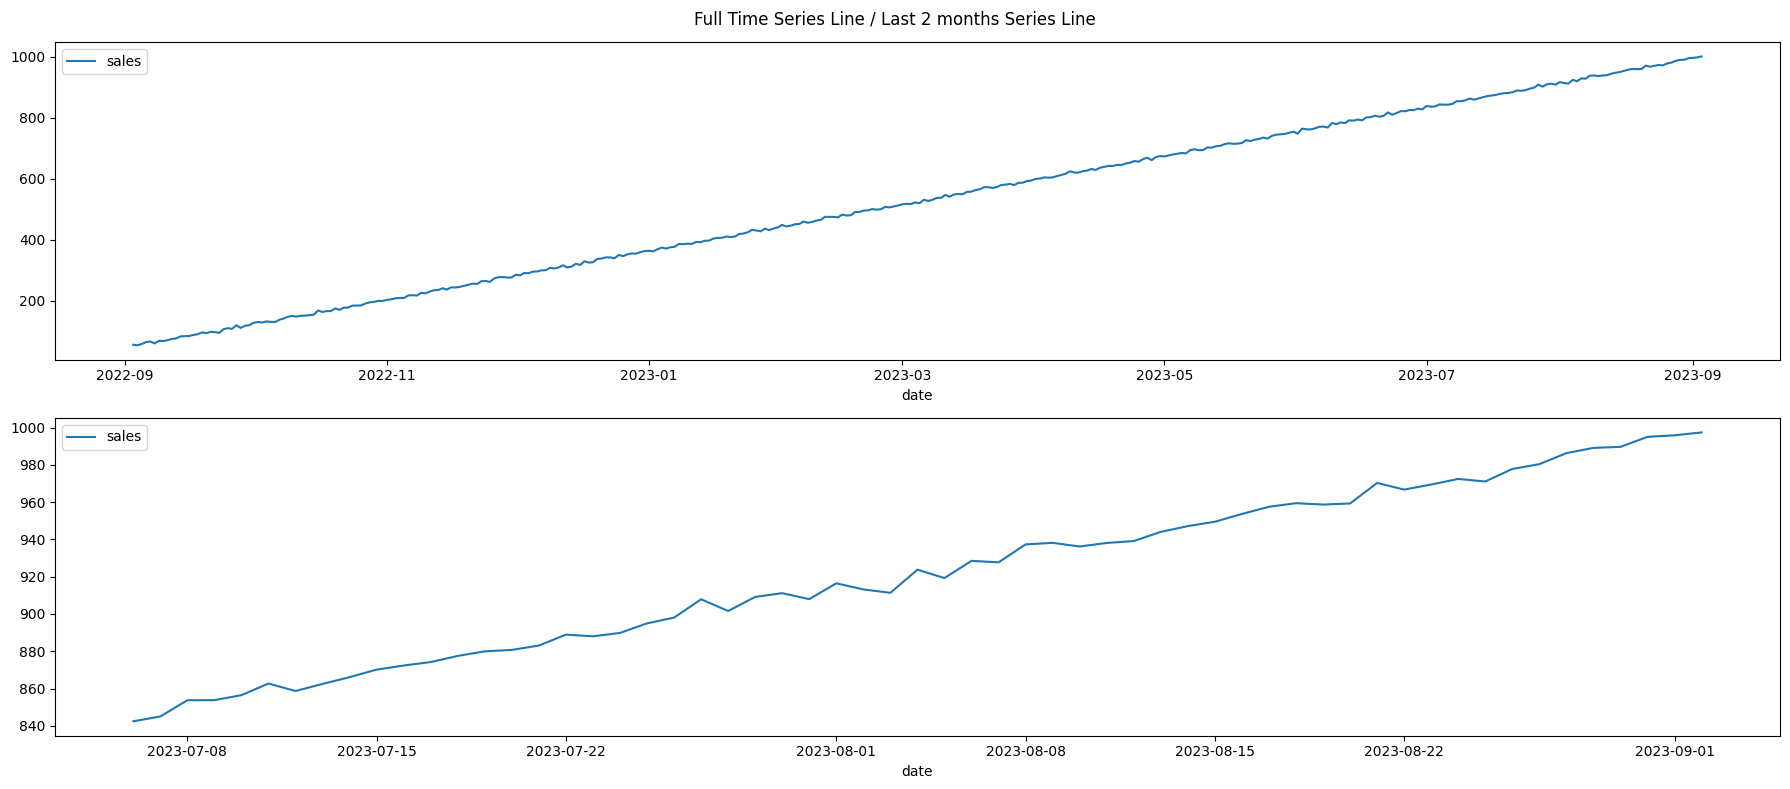

In [16]:
fig, axis = plt.subplots(2,1,figsize=(18,8))
plt.suptitle('Full Time Series Line / Last 2 months Series Line')
sns.lineplot(data = df,ax=axis[0])
sns.lineplot(data = df[-60:-1],ax=axis[1])
plt.tight_layout()
plt.show()

### Answer the following questions:
*   Which is the tensor of the time serie?

                The tensor for this simple serie, seems to be a vector (range 1) expresed by the values included in column 'sales'.


In [17]:
# Para responder la proxima pregunta debo descomponer la serie, lo hare de manera mensual
decomposition = seasonal_decompose(df, period = 12)
decomposition

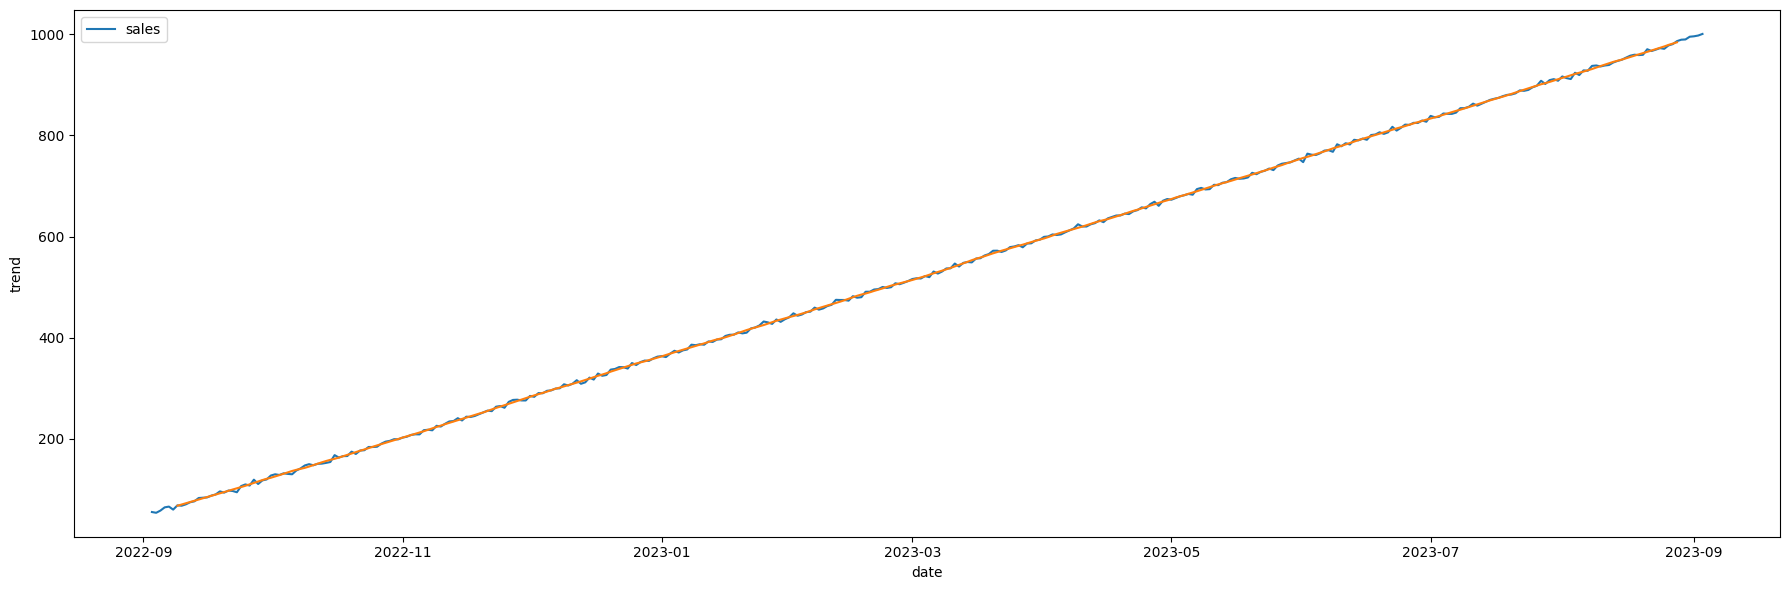

In [18]:
trend = decomposition.trend
fig, axis = plt.subplots(figsize=(18,6))
sns.lineplot(data = df)
sns.lineplot(data = trend)
plt.tight_layout()
plt.show()

*   Which is the trend?

        The big picture is showing us a pattern of constant increase in all data series

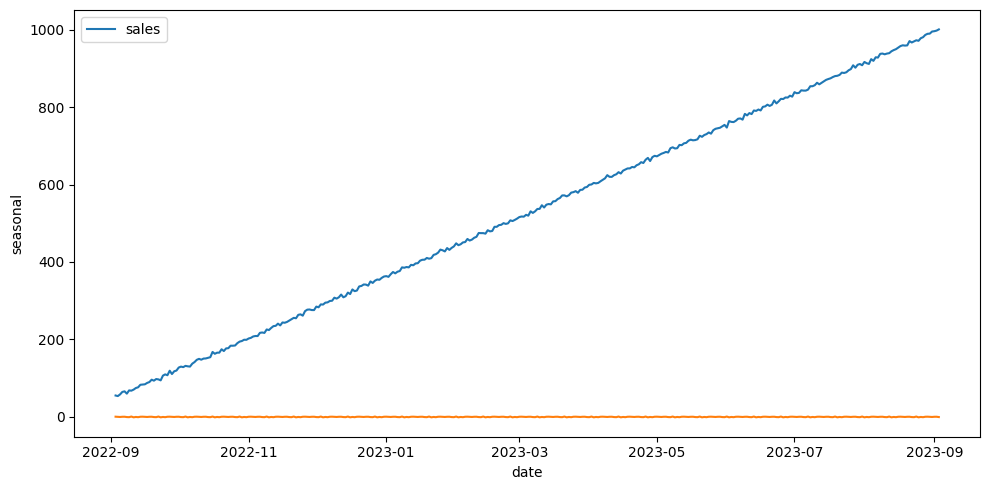

In [19]:
seasonal = decomposition.seasonal
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df)
sns.lineplot(data = seasonal)
plt.tight_layout()
plt.show()

In [20]:
def test_stationarity(timeseries):
    print("Dickey-Fuller Test Results")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Dickey-Fuller Test Results


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

*   Is it stationary?

        This numbers suggest that the time series is not stationary. We should say that the test is failing to reject the null-hypothesis of non-stationary

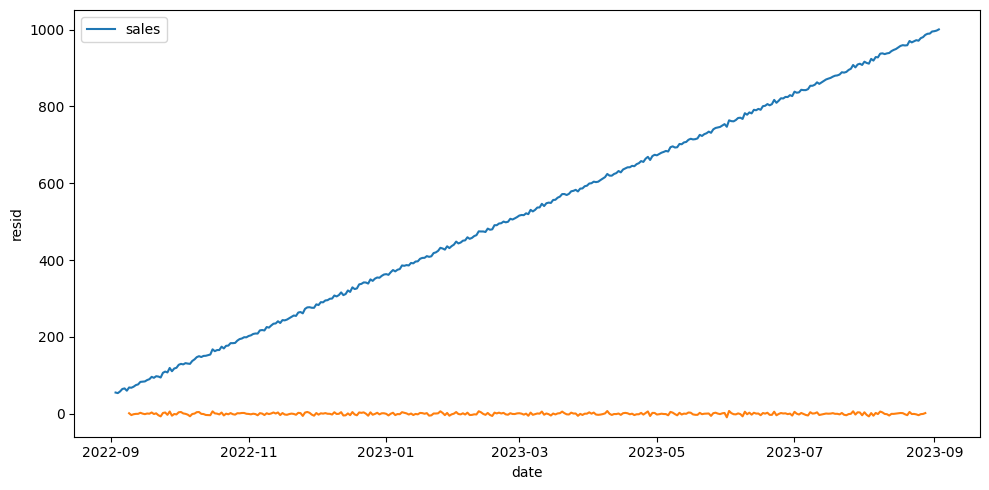

In [21]:
residual = decomposition.resid
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df)
sns.lineplot(data = residual)
plt.tight_layout()
plt.show()

*   Is there variability or noise?

        We can observe the noise is present but very low amplitude, practically insignificant. Fluctuations around zero suggest that there isn't much explanined variability after accounting for the trend, so residuals mostly capture minor random variables.

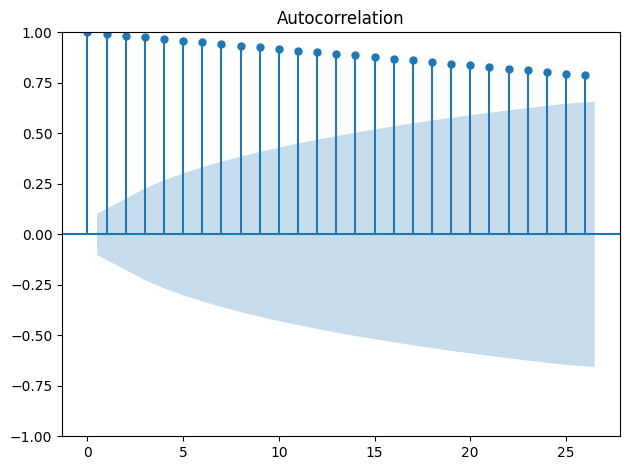

In [22]:
# Grafico de Autocorrelacion para medir como los valores se encuentran relacionados con sus rezagos a traves del tiempo
plot_acf(df)
plt.tight_layout()
plt.show()

Key observations from the ACF:
- High autocorrelation at all tags: values close to 1 suggests that the time series exhibit strong autocorrelation over time. This means past values are higly predictive for future values, and strong temporal dependence in the data
- Non-stationary: the autocorrelation is persistantly high and doesn't drop off quickly, simphtom of a typical non-stationary time series. In a stationary series, autocorrelation would drop towards 0 relatively quikcly as the lag increases .

## Step 3: Train an ARIMA
Use the training data to find the best parameterization of your ARIMA model.

In [23]:
# Segun lo visto en la parte teorica de la web, para realizar un arima se debe convertir la serie a estacionaria.

# df_stationary = df.diff().dropna()
# test_stationarity(df_stationary)

# Comento esta celda porque haciendo esto, los valores predichos funcionan mucho peor que sin convertir la serie

### Now that we've converted the time series to stationary, wo should proceed with Arima Training

In [24]:
# Defino los subset de train y test
df_train, df_test = df.iloc[:-60], df.iloc[-60:]    # Defino los ultimos 2 meses como el subset de test

In [25]:
# Defino el modelo autoarima
model = auto_arima(df_train, seasonal = True, trace = True, m =12) # elijo m=12 para identificar patrones mensuales de estacionalidad

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1552.588, Time=2.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1762.723, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1659.837, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1548.067, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1853.658, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1546.075, Time=0.24 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1548.068, Time=1.42 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1550.074, Time=2.78 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1545.060, Time=0.53 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1547.045, Time=0.72 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1547.046, Time=0.81 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1549.026, Time=0.97 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1658.000, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1546.949, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  306
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -768.480
Date:                Thu, 12 Sep 2024   AIC                           1544.960
Time:                        20:52:18   BIC                           1559.841
Sample:                    09-03-2022   HQIC                          1550.912
                         - 07-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5982      0.012    213.699      0.000       2.574       2.622
ma.L1         -1.0378      0.053    -19.671      0.000      -1.141      -0.934
ma.L2          0.1051      0.053      1.991      0.046       0.002       0.209
sigma2         8.9736      0.786     11.419      0.000       7.433      10.514
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.98   Prob(JB):                         0.59
Heteroskedasticity (H):               0.87   Skew:                             0.06
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Step 4: Predict with the test set
Now use the trained model with the test set and compare the points with the real ones. Measure the performance of the time serie.

In [27]:
# Hago una prediccion y comparo con los dias del df_test
forecast = model.predict(60)
forecast

2023-07-06     846.919304
2023-07-07     849.343136
2023-07-08     851.941328
2023-07-09     854.539520
2023-07-10     857.137712
2023-07-11     859.735904
2023-07-12     862.334095
2023-07-13     864.932287
2023-07-14     867.530479
2023-07-15     870.128671
2023-07-16     872.726863
2023-07-17     875.325055
2023-07-18     877.923247
2023-07-19     880.521438
2023-07-20     883.119630
2023-07-21     885.717822
2023-07-22     888.316014
2023-07-23     890.914206
2023-07-24     893.512398
2023-07-25     896.110589
2023-07-26     898.708781
2023-07-27     901.306973
2023-07-28     903.905165
2023-07-29     906.503357
2023-07-30     909.101549
2023-07-31     911.699740
2023-08-01     914.297932
2023-08-02     916.896124
2023-08-03     919.494316
2023-08-04     922.092508
2023-08-05     924.690700
2023-08-06     927.288892
2023-08-07     929.887083
2023-08-08     932.485275
2023-08-09     935.083467
2023-08-10     937.681659
2023-08-11     940.279851
2023-08-12     942.878043
2023-08-13  

In [28]:
df_comparison = pd.concat((forecast,df_test[:60]), axis=1, join='inner')
df_comparison

,0,sales
2023-07-06,846.919304,842.435581
2023-07-07,849.343136,845.000943
2023-07-08,851.941328,853.725155
2023-07-09,854.539520,853.767855
2023-07-10,857.137712,856.448210
2023-07-11,859.735904,862.685286
2023-07-12,862.334095,858.674317
2023-07-13,864.932287,862.465501
2023-07-14,867.530479,866.105635
2023-07-15,870.128671,870.146068


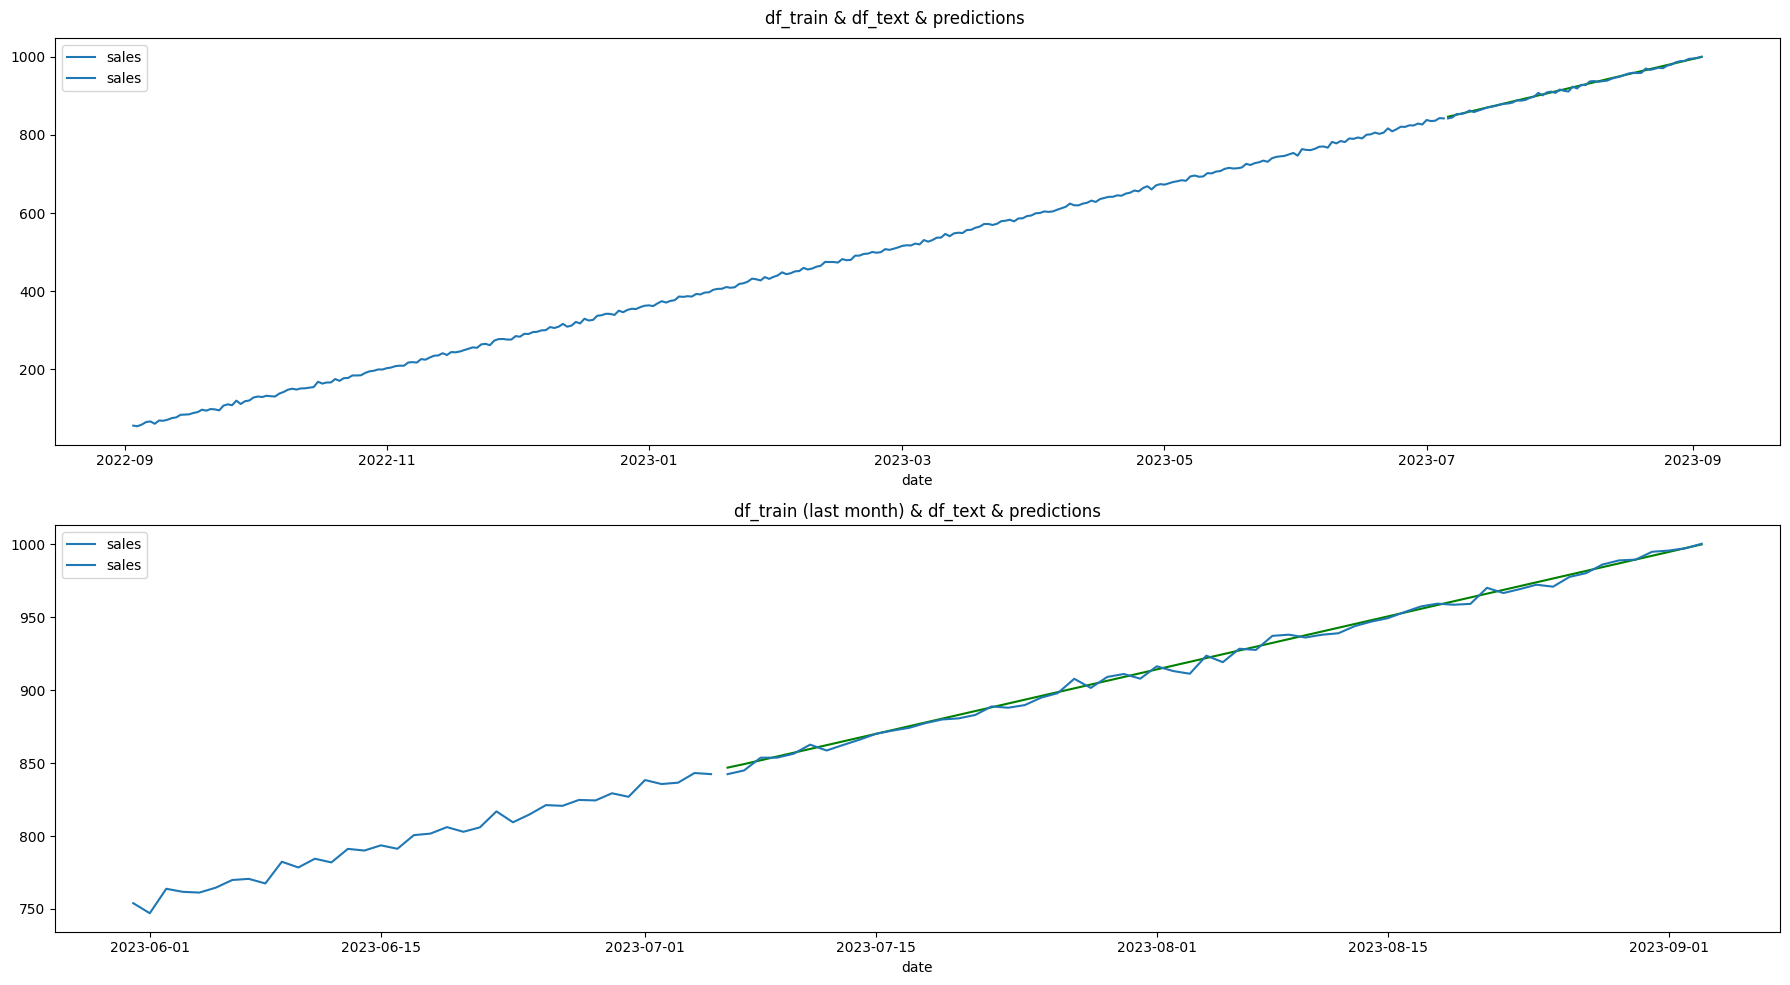

In [29]:
fig, axis = plt.subplots(2,1,figsize = (18, 10))
plt.suptitle('df_train & df_text & predictions')
sns.lineplot(data = df_train, c = 'blue', ax=axis[0])
sns.lineplot(data = forecast, c = "green", ax=axis[0])
sns.lineplot(data = df_test, c = "red", ax=axis[0])
plt.title('df_train (last month) & df_text & predictions')
sns.lineplot(data = df_train[270:], c = 'blue', ax=axis[1])
sns.lineplot(data = forecast, c = "green", ax=axis[1])
sns.lineplot(data = df_test, c = "red", ax=axis[1])

plt.tight_layout()

plt.show()

The model's predictions closely follow the actual sales with minimal deviations. Even when we can identify slight differences some days, the trend and magnitude predictions align very well with the real sales data, a fact that I find very surprising.

## Step 5: Save the model

In [46]:
#dump(model, open("auto_arima-seasonal=True-trace=True-m=12.sav", "wb"))